# Vehicle Detection and Tracking

## Histogram of Oriented Gradients (HOG)

In this section, we focus on extracting HOG features out of images. Mainly includes find which color space to use and tuning HOG parameters(orientations, pixels_per_cell, cells_per_block)

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

Read from images and test on the HOG function.

In [2]:
# Divide up into cars and notcars
v_filepaths = ['./data/vehicles/GTI_Far/'
               ,'./data/vehicles/GTI_Left/'
               ,'./data/vehicles/GTI_MiddleClose/'
               ,'./data/vehicles/GTI_Right/'
               ,'./data/vehicles/KITTI_extracted/']
nv_filepaths = ['./data/non-vehicles/GTI/'
                , './data/non-vehicles/Extras/']

v_images = []
nv_images = []

for v_filepath in v_filepaths:
    v_images += glob.glob(v_filepath + '*.png')
for nv_filepath in nv_filepaths:
    nv_images += glob.glob(nv_filepath + '*.png')

cars = []
notcars = []
for image in v_images:
    cars.append(image)
for image in nv_images:
    notcars.append(image)
    
print('The size of cars images {} and the size of non-cars images is {}'
      .format(len(cars), len(notcars)))

The size of cars images 8792 and the size of non-cars images is 8968


The size of the cars and non-cars images are almost the same so we don't need to worry about the dataset balance.

Sample of car and notcar image.


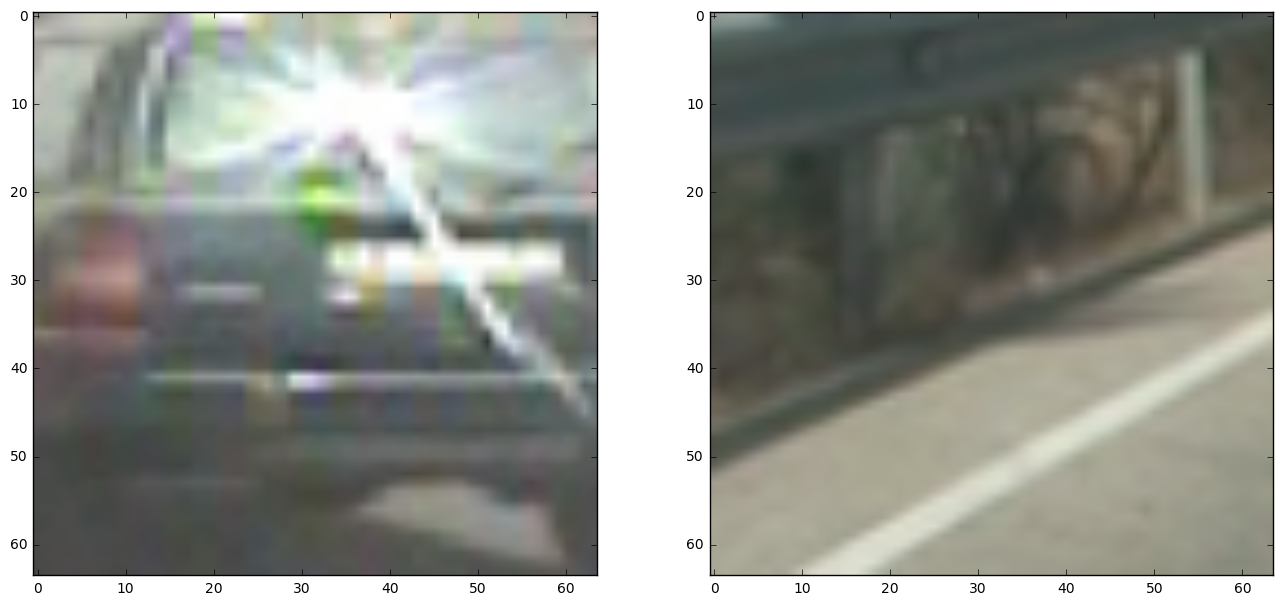

In [3]:
import random

car_sample_num = random.randint(0, len(cars))
notcar_sample_num = random.randint(0, len(notcars))

car_sample = cv2.cvtColor(cv2.imread(cars[car_sample_num]), cv2.COLOR_BGR2RGB)
notcar_sample = cv2.cvtColor(cv2.imread(notcars[notcar_sample_num]), cv2.COLOR_BGR2RGB)

print("Sample of car and notcar image.")
fig = plt.figure(1,figsize=(16,8))

plt.subplot(121)
plt.imshow(car_sample, cmap='gray')

plt.subplot(122)
plt.imshow(notcar_sample, cmap='gray')

plt.show()

I then explored different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). 

### 1. Color Space

In [4]:
# Define a function to take experiments with hog features.
def hog_experiment(image, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), need_vis=False):  
    features = []
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      

    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        hog_images = []
        for channel in range(feature_image.shape[2]):
            if need_vis is False:
                h_features = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True)
                hog_features.append(h_features)
            else:
                h_features, hog_image = get_hog_features(feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=True, feature_vec=True)
                hog_features.append(h_features)
                hog_images.append(hog_image)
            
        hog_features = np.ravel(hog_features)        
    else:
        hog_images = []
        if need_vis is False:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        else:
            hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                    pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            hog_images.append(hog_image)
        
    # Append the new feature vector to the features list
    features.append(hog_features)
    
    if need_vis is False:
        return features
    else:
        return features, hog_images
    
# Plot the examples
def plotHogFeatures(image, hogs, cspace='RGB'):
#     cspace = 'RGB'
#     image = car_sample
#     hogs = rgb_car_hog_images
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)

    fig = plt.figure()
    matplotlib.rc('font', size=6)
    fig.suptitle("Hog features of {} color space.".format(cspace), fontsize=12)
    plt.subplot(231)
    plt.imshow(feature_image[:,:,0], cmap='gray')
    plt.title('Car CH-1')
    plt.subplot(232)
    plt.imshow(feature_image[:,:,1], cmap='gray')
    plt.title('Car CH-2')
    plt.subplot(233)
    plt.imshow(feature_image[:,:,2], cmap='gray')
    plt.title('Car CH-3')
    plt.subplot(234)
    plt.imshow(hogs[0], cmap='gray')
    plt.title('Car CH-1 HOG')
    plt.subplot(235)
    plt.imshow(hogs[1], cmap='gray')
    plt.title('Car CH-2 HOG')
    plt.subplot(236)
    plt.imshow(hogs[2], cmap='gray')
    plt.title('Car CH-3 HOG')

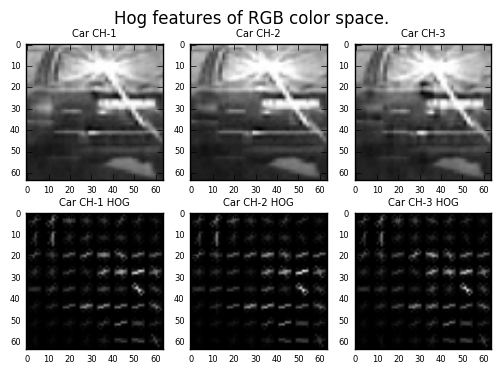

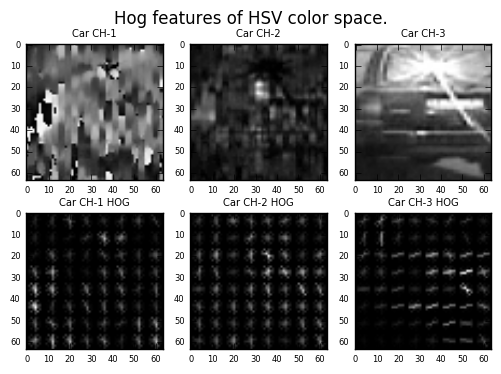

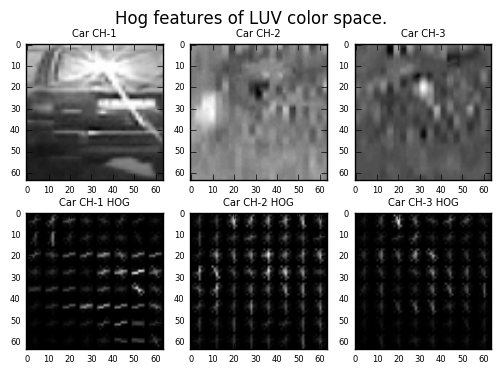

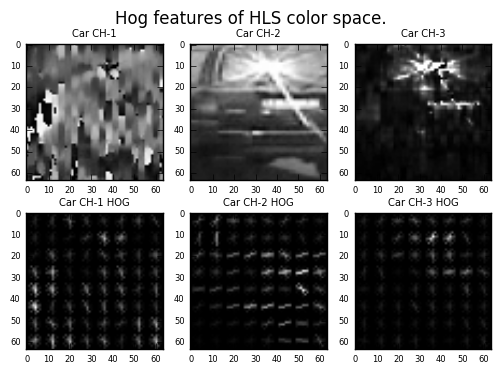

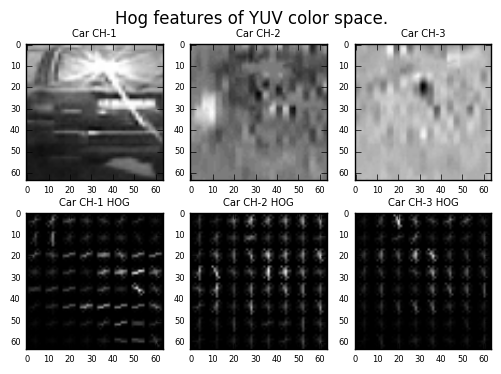

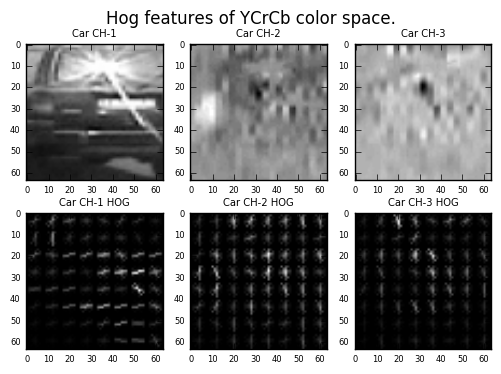

In [5]:
# Experiment of different color space and hog features.
rgb_car_features, rgb_car_hog_images = hog_experiment(car_sample, hog_channel='ALL', need_vis=True)
hsv_car_features, hsv_car_hog_images = hog_experiment(car_sample, cspace='HSV', hog_channel='ALL', need_vis=True)
luv_car_features, luv_car_hog_images = hog_experiment(car_sample, cspace='LUV', hog_channel='ALL', need_vis=True)
hls_car_features, hls_car_hog_images = hog_experiment(car_sample, cspace='HLS', hog_channel='ALL', need_vis=True)
yuv_car_features, yuv_car_hog_images = hog_experiment(car_sample, cspace='YUV', hog_channel='ALL', need_vis=True)
ycrcb_car_features, ycrcb_car_hog_images = hog_experiment(car_sample, cspace='YCrCb', hog_channel='ALL', need_vis=True)

plotHogFeatures(car_sample, rgb_car_hog_images, cspace='RGB')
plotHogFeatures(car_sample, hsv_car_hog_images, cspace='HSV')
plotHogFeatures(car_sample, luv_car_hog_images, cspace='LUV')
plotHogFeatures(car_sample, hls_car_hog_images, cspace='HLS')
plotHogFeatures(car_sample, yuv_car_hog_images, cspace='YUV')
plotHogFeatures(car_sample, ycrcb_car_hog_images, cspace='YCrCb')

We extract the hog features of different color spaces and get the above results. From the results we can find that the RGB hog features is almost the same across the 3 channels. The HSV and the HLS hog features are almost the same since Value in HSV space is much of the same meaning as the Lightness in HLS. The LUV, YUV and YCrCb hog features are almost the same as they are much of the same color space. 

So we get rid of RGB color space as an option and will simply use YCrCb as the color space in the following discussion.

### 2. HOG Params
After many param tuning we define the params in the feat_extraction_params map below.

In [6]:
feat_extraction_params = {
    'resizeh': 64, # resize image height before feat extraction 
    'resizew': 64, # resize image height before feat extraction 
    'colorspace': 'YCrCb', # Can be RGB, HSV, LUV, HLS, YUV, YCrCb 
    'orient': 9, # HOG orientations 
    'pixpercell': 8, # HOG pixels per cell 
    'cellperblock': 2, # HOG cells per block 
    'hogchannel': "ALL", # Can be 0, 1, 2, or "ALL" 
    'spatialsize': (32, 32), # Spatial binning dimensions 
    'histbins': 16 # Number of histogram bins 
} 

### 3. Training the classifier
To train the classifier includes several steps:
1. Read all images from cars and not-cars folders. (Done)
2. Extract hog features, spital bin and color histogram features from the images. (See extract_features function below)
3. Shuffle the dataset and train the SVM model.

In [7]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))        
        
    # Return list of feature vectors
    return features

In [8]:
t=time.time()
car_features = extract_features(cars
                                , cspace=feat_extraction_params['colorspace']
                                , orient=feat_extraction_params['orient']
                                , pix_per_cell=feat_extraction_params['pixpercell']
                                , cell_per_block=feat_extraction_params['cellperblock']
                                , hog_channel=feat_extraction_params['hogchannel']
                                , spatial_size=feat_extraction_params['spatialsize']
                                , hist_bins=feat_extraction_params['histbins'])
notcar_features = extract_features(notcars
                                , cspace=feat_extraction_params['colorspace']
                                , orient=feat_extraction_params['orient']
                                , pix_per_cell=feat_extraction_params['pixpercell']
                                , cell_per_block=feat_extraction_params['cellperblock']
                                , hog_channel=feat_extraction_params['hogchannel']
                                , spatial_size=feat_extraction_params['spatialsize']
                                , hist_bins=feat_extraction_params['histbins'])
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

142.91 Seconds to extract HOG features...


In [9]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Feature vector length: 8412
28.77 Seconds to train SVC...
Test Accuracy of SVC =  0.9854
My SVC predicts:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  1.  1.  1.  1.  0.  0.]
0.00262 Seconds to predict 10 labels with SVC


We take some samples to see what the features we extract look like.

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

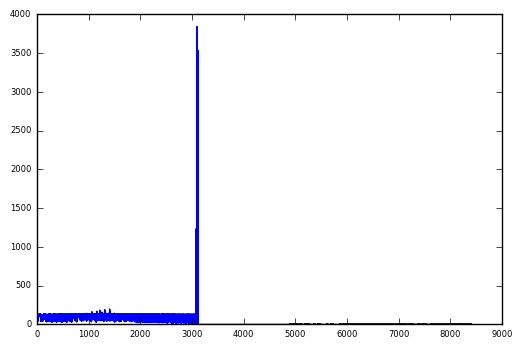

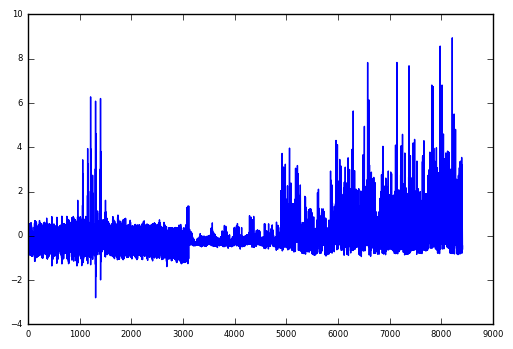

In [10]:
test_car = cars[1000:1010]
test_car += notcars[1000:1010]
# plt.imshow(cv2.cvtColor(cv2.imread(test_car), cv2.COLOR_BGR2RGB), cmap='gray')
fe = extract_features(test_car
                    , cspace=feat_extraction_params['colorspace']
                    , orient=feat_extraction_params['orient']
                    , pix_per_cell=feat_extraction_params['pixpercell']
                    , cell_per_block=feat_extraction_params['cellperblock']
                    , hog_channel=feat_extraction_params['hogchannel']
                    , spatial_size=feat_extraction_params['spatialsize']
                    , hist_bins=feat_extraction_params['histbins'])

fig = plt.figure()
plt.plot(fe[0])

fe = X_scaler.transform(fe)

fig = plt.figure()
plt.plot(fe[0])

svc.predict(fe)

## Sliding Window Search

In this section we mainly discuss the way of sliding window search and detect the cars in the windows. Here are some points we should look into:

1. The cars usually come out in the lower region of the images, so we will focus on detecting cars in the lower region.

2. The hog features extraction is a resource-consuming operation but luckily we can sub-sample the hog features of the whole image and get the result we want.

At first we extract the features for each image crop and see what we can get.

There are 152 windows total and find 9 of them with cars.
There are 48 windows total and find 4 of them with cars.
There are 18 windows total and find 2 of them with cars.
There are 0 windows total and find 0 of them with cars.
1.60041 Seconds to perform sliding window operation


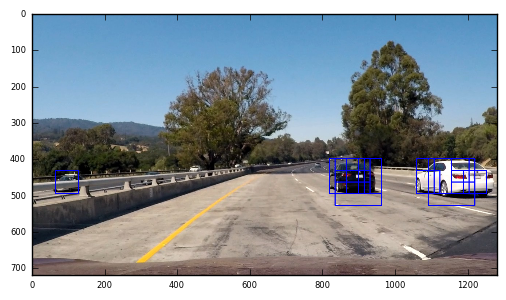

In [11]:
def extract_fe(image, orient=9, 
                        pix_per_cell=8, cell_per_block=2,
                        spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    feature_image = np.copy(image)      

    hog_features = []
    for channel in range(feature_image.shape[2]):
        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                            orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True))
    hog_features = np.ravel(hog_features)        
    
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Append the new feature vector to the features list
    return np.concatenate((spatial_features, hist_features, hog_features))    
    

def find_cars(image, y_start, y_stop, scale, svc, feature_scaler, feat_extr_params, debug=False):
    hot_windows = []

    resize_h = feat_extr_params['resizeh']
    resize_w = feat_extr_params['resizew']
    color_space = feat_extr_params['colorspace']
    spatial_size = feat_extr_params['spatialsize']
    hist_bins = feat_extr_params['histbins']
    orient = feat_extr_params['orient']
    pix_per_cell = feat_extr_params['pixpercell']
    cell_per_block = feat_extr_params['cellperblock']
    
    draw_img = np.copy(image)
    
    image_crop = cv2.cvtColor(image[y_start:y_stop, :, :], cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = image_crop.shape
        image_crop = cv2.resize(image_crop, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))
    
    # Define blocks and steps as above
    n_x_blocks = (image_crop[:,:,0].shape[1] // pix_per_cell) - 1
    n_y_blocks = (image_crop[:,:,0].shape[0] // pix_per_cell) - 1
    
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    window_counter = 0
    car_counter = 0
    
    features = []
    sub_images = []
    
    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            window_counter += 1
            
            y_pos = yb * cells_per_step
            x_pos = xb * cells_per_step      

            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(image_crop[y_top:y_top + window, x_left:x_left + window], (resize_w, resize_h))
            
            con_features = extract_fe(subimg
                            , orient=feat_extraction_params['orient']
                            , pix_per_cell=feat_extraction_params['pixpercell']
                            , cell_per_block=feat_extraction_params['cellperblock']
                            , spatial_size=feat_extraction_params['spatialsize']
                            , hist_bins=feat_extraction_params['histbins'])
            
            sub_images.append(subimg)
            features.append(con_features)

            # Scale features and make a prediction
            test_features = X_scaler.transform(con_features.reshape(1,-1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1: 
                car_counter += 1
                xbox_left = np.int(x_left * scale)
                ytop_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                tl_corner_draw = (xbox_left, ytop_draw + y_start)
                br_corner_draw = (xbox_left + win_draw, ytop_draw + win_draw + y_start)

                cv2.rectangle(draw_img, tl_corner_draw, br_corner_draw, (0, 0, 255), 6)

                hot_windows.append((tl_corner_draw, br_corner_draw))

    print("There are {} windows total and find {} of them with cars.".format(window_counter, car_counter))
          
    if debug is True:
        return hot_windows, draw_img, features, sub_images
    else: 
        return hot_windows

# # Debug mode
# image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)
# hot_windows, draw_image, features, sub_images = find_cars(image, 400, 600, 1.0, svc, X_scaler, feat_extraction_params)
image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

t=time.time()
hot_windows = []
for subsample in np.arange(1.0,3.0,0.5):
    hot_windows += find_cars(image, 400, 600, subsample, svc, X_scaler, feat_extraction_params)
draw_image = image.copy()
for window in hot_windows:
    draw_image = cv2.rectangle(draw_image, window[0], window[1], (0, 0, 255), thickness=2)
    
plt.imshow(draw_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to perform sliding window operation')

Then we extract the hog feature out of the whole image and sub-sample the hog feature of the image crops out of the result we get to see what the performance can change.

0.97297 Seconds to perform sliding window operation


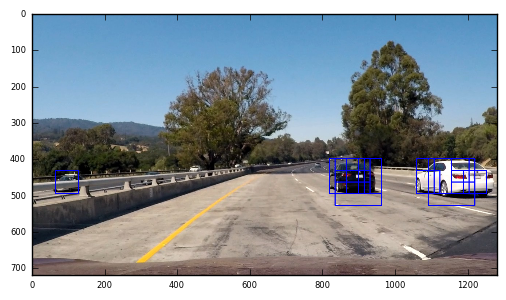

In [12]:
def find_cars(image, y_start, y_stop, scale, svc, feature_scaler, feat_extr_params):
    hot_windows = []

    resize_h = feat_extr_params['resizeh']
    resize_w = feat_extr_params['resizew']
    color_space = feat_extr_params['colorspace']
    spatial_size = feat_extr_params['spatialsize']
    hist_bins = feat_extr_params['histbins']
    orient = feat_extr_params['orient']
    pix_per_cell = feat_extr_params['pixpercell']
    cell_per_block = feat_extr_params['cellperblock']
    
    draw_img = np.copy(image)
    
    image_crop = cv2.cvtColor(image[y_start:y_stop, :, :], cv2.COLOR_RGB2YCrCb)
    
    if scale != 1:
        imshape = image_crop.shape
        image_crop = cv2.resize(image_crop, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = image_crop[:, :, 0]
    ch2 = image_crop[:, :, 1]
    ch3 = image_crop[:, :, 2]
    
    # Define blocks and steps as above
    n_x_blocks = (ch1.shape[1] // pix_per_cell) - 1
    n_y_blocks = (ch1.shape[0] // pix_per_cell) - 1
    
    window = 64
    n_blocks_per_window = (window // pix_per_cell) - 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    n_x_steps = (n_x_blocks - n_blocks_per_window) // cells_per_step
    n_y_steps = (n_y_blocks - n_blocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(n_x_steps):
        for yb in range(n_y_steps):
            y_pos = yb * cells_per_step
            x_pos = xb * cells_per_step

            # Extract HOG for this patch
            hog_feat1 = hog1[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat2 = hog2[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_feat3 = hog3[y_pos:y_pos + n_blocks_per_window, x_pos:x_pos + n_blocks_per_window].ravel()
            hog_features = []
            hog_features.append(hog_feat1)
            hog_features.append(hog_feat2)
            hog_features.append(hog_feat3)
            hog_features = np.ravel(hog_features)        

            x_left = x_pos * pix_per_cell
            y_top = y_pos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(image_crop[y_top:y_top + window, x_left:x_left + window], (resize_w, resize_h))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = feature_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(x_left * scale)
                ytop_draw = np.int(y_top * scale)
                win_draw = np.int(window * scale)
                tl_corner_draw = (xbox_left, ytop_draw + y_start)
                br_corner_draw = (xbox_left + win_draw, ytop_draw + win_draw + y_start)

                cv2.rectangle(draw_img, tl_corner_draw, br_corner_draw, (0, 0, 255), 6)

                hot_windows.append((tl_corner_draw, br_corner_draw))

    return hot_windows


t=time.time()
hot_windows = []
for subsample in np.arange(1.0,3.0,0.5):
    hot_windows += find_cars(image, 400, 600, subsample, svc, X_scaler, feat_extraction_params)
draw_image = image.copy()
for window in hot_windows:
    draw_image = cv2.rectangle(draw_image, window[0], window[1], (0, 0, 255), thickness=2)
    
plt.imshow(draw_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to perform sliding window operation')

So from the result we can find out that after the performance optimization we save about 1/3 of the total operation time.

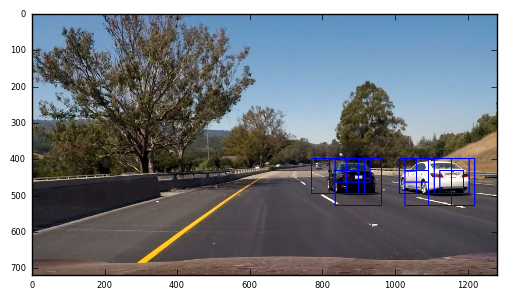

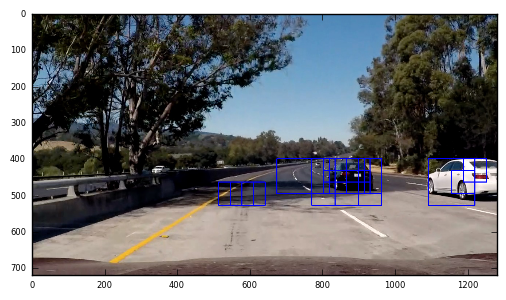

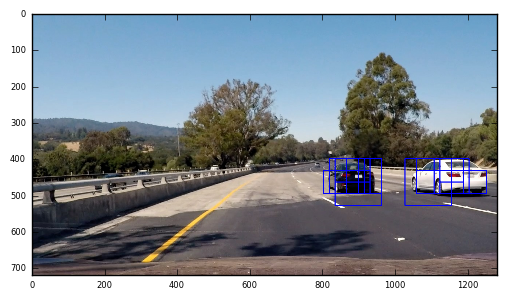

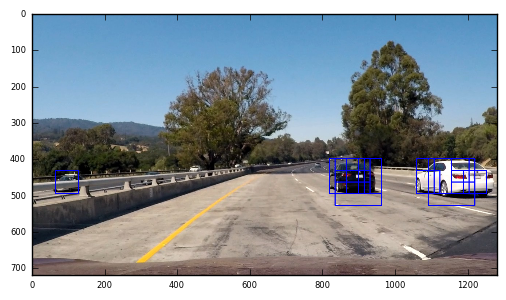

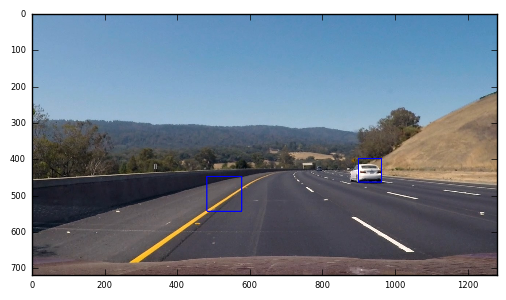

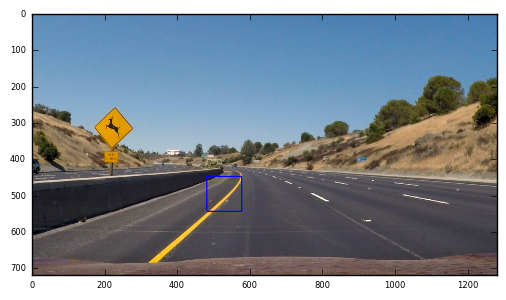

In [13]:
test_files = glob.glob('./test_images/*.jpg')
for test_file in test_files:
    image = cv2.cvtColor(cv2.imread(test_file), cv2.COLOR_BGR2RGB)
    draw_image = image.copy()
    
    hot_windows = []
    for subsample in np.arange(1.0,3.0,0.5):
        hot_windows += find_cars(image, 400, 600, subsample, svc, X_scaler, feat_extraction_params)

    for window in hot_windows:
        draw_image = cv2.rectangle(draw_image, window[0], window[1], (0, 0, 255), thickness=2)

    fig = plt.figure()
    plt.imshow(draw_image)

For the test images, we get the car detection results above. From the results we can find that there are false positive situations and we should do something to provide that happen.

## Video Implementation

From above we can see that for one car there maybe multiple windows detected. To combine the multiple windows we compute the heatmap of the windows and apply a threshold to get rid of the noise.

1.03733 Seconds to perform sliding window operation
3 cars found


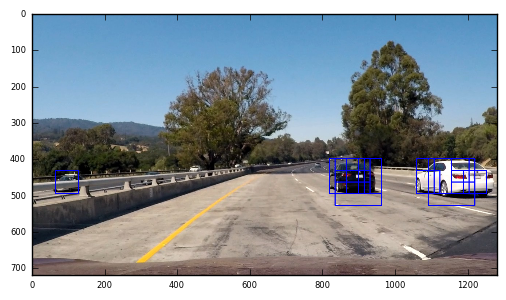

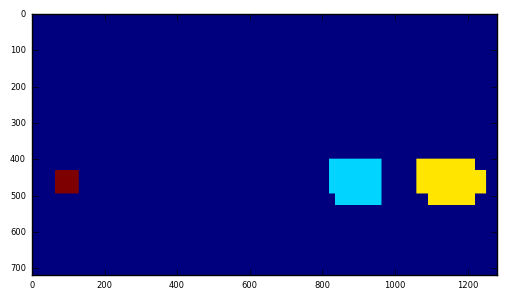

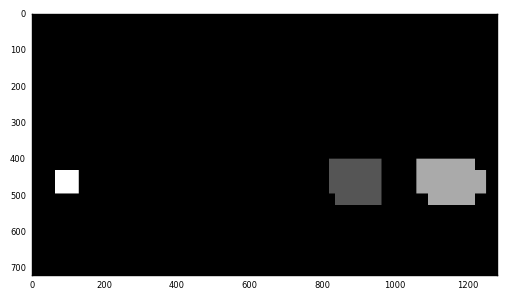

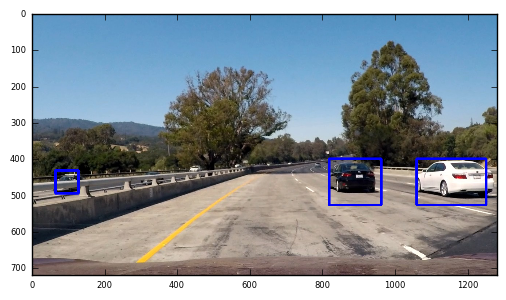

In [40]:
from scipy.ndimage.measurements import label

def get_heatmap(image, hot_windows):
    h, w, c = image.shape
    
    heatmap = np.zeros(shape=(h, w), dtype = np.uint8)
    
    for window in hot_windows:
        xmin, ymin = window[0]
        xmax, ymax = window[1]
        heatmap[ymin:ymax, xmin:xmax] += 1
    
    return heatmap
        
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap
    
def draw_labeled_windows(image, labels):
    for car_num in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_num).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a window based on min/max x and y
        window = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the window on the image
        cv2.rectangle(image, window[0], window[1], (0,0,255), 6)
    return image

image = cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB)

t=time.time()
hot_windows = []
for subsample in np.arange(1.0,3.0,0.5):
    hot_windows += find_cars(image, 400, 600, subsample, svc, X_scaler, feat_extraction_params)
draw_image = image.copy()
for window in hot_windows:
    draw_image = cv2.rectangle(draw_image, window[0], window[1], (0, 0, 255), thickness=2)
    
plt.imshow(draw_image)
t2 = time.time()
print(round(t2-t, 5), 'Seconds to perform sliding window operation')

threshold = 0
heatmap = get_heatmap(image, hot_windows)
fig = plt.figure()
plt.imshow(labels[0])

heatmap = apply_threshold(heatmap, threshold)
labels = label(heatmap)

print(labels[1], 'cars found')
fig = plt.figure()
plt.imshow(labels[0], cmap='gray')

fig = plt.figure()
plt.imshow(draw_labeled_windows(image, labels))

The function below is the pipeline for detecting cars out of frames.

In [36]:
import queue

memy = 3
heatmap_his = queue.Queue(memy)

def pipeline(image, debug=False):
    # Apply sliding window search on the images.
    draw_image = image.copy()
    
    hot_windows = []
    for subsample in np.arange(1.0,3.0,0.5):
        hot_windows += find_cars(image, 400, 600, subsample, svc, X_scaler, feat_extraction_params)

    for window in hot_windows:
        draw_image = cv2.rectangle(draw_image, window[0], window[1], (0, 0, 255), thickness=2)

    if debug is True:
        fig = plt.figure()
        plt.title('raw detected windows')
        plt.imshow(draw_image)
    
    # Apply hot window and threshold to get rid of noise.
    heatmap_memy = []
    threshold = 25
    heatmap = get_heatmap(image, hot_windows)
    
#     if heatmap_his.qsize() > 0:
#         print('heatmap_his: {}'.format(heatmap_his.qsize()))
#     else:
#         print('heatmap_his: {}'.format(0))

    combined_heatmap = heatmap
    if heatmap_his.qsize() > 0:
        history_list = list(heatmap_his.queue)
        for i in range(len(history_list)):
            history = history_list[len(history_list) - i - 1]
            # half-life period equals to a frame
            combined_heatmap = combined_heatmap*2 + history
    
    combined_heatmap = apply_threshold(combined_heatmap, threshold)
    
    if heatmap_his.qsize() == memy:
        # pop up the first element if the queue is full
        heatmap_his.get()

    heatmap_his.put(heatmap)
        
    labels = label(combined_heatmap)
    labeled_image = draw_labeled_windows(image, labels)

    if debug is True:
        print(labels[1], 'cars found')
        fig = plt.figure()
        plt.title('heatmap')
        plt.imshow(heatmap, cmap='gray')

        fig = plt.figure()
        plt.title('labeled cars')
        plt.imshow(labeled_image)
    
    return labeled_image
    
frame = pipeline(cv2.cvtColor(cv2.imread('./test_images/test1.jpg'), cv2.COLOR_BGR2RGB))  

Process the video.

In [37]:
from moviepy.editor import VideoFileClip

selector = 'test'
clip = VideoFileClip('./{}_video.mp4'.format(selector)).fl_image(pipeline)
clip.write_videofile('./out_{}_video.mp4'.format(selector), audio=False)

[MoviePy] >>>> Building video ./out_test_video.mp4
[MoviePy] Writing video ./out_test_video.mp4


 97%|█████████▋| 38/39 [00:36<00:00,  1.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_test_video.mp4 



In [38]:
selector = 'project'
clip = VideoFileClip('./{}_video.mp4'.format(selector)).fl_image(pipeline)
clip.write_videofile('./out_{}_video.mp4'.format(selector), audio=False)

[MoviePy] >>>> Building video ./out_project_video.mp4
[MoviePy] Writing video ./out_project_video.mp4


100%|█████████▉| 1260/1261 [19:10<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./out_project_video.mp4 

